In [135]:
# Cell 1: Import Libraries and Set Paths
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Concatenate,
)

# --- Set Base Path ---
# Please set the base path where your dataset is stored.
# Example: 'C:/Users/Hyukki/Downloads/LeFood-Set'
BASE_PATH = "LeFood-Set"

# Set paths for data file and image folders
excel_path = os.path.join(BASE_PATH, "data_original.xlsx")
before_img_folder = os.path.join(
    BASE_PATH, "leftover dataset", "data_before"
)
after_img_folder = os.path.join(
    BASE_PATH, "leftover dataset", "data_after"
)

print("Libraries imported and paths configured.")

Libraries imported and paths configured.


In [137]:
# Cell 2 (Modified): Load, Filter, and Split Data in one go

try:
    df = pd.read_excel(excel_path)
except FileNotFoundError:
    print(
        f"Error: Excel file not found. Please check the path: {excel_path}"
    )
    df = None

if df is not None:
    print(f"Total data loaded from Excel file: {len(df)}")

    # --- Start Data Filtering ---
    # List to store indices of data with existing image files
    valid_indices = []
    for index, row in df.iterrows():
        # Generate image paths for 'Before Eaten' and 'After Eaten'
        before_img_name = row["Image Before Eaten"]
        after_img_name = row["Image After Eaten"]

        before_sub_folder = before_img_name.split("_")[0]
        after_sub_folder = after_img_name.split("_")[0]

        before_path = os.path.join(
            before_img_folder, before_sub_folder, before_img_name
        )
        after_path = os.path.join(
            after_img_folder, after_sub_folder, after_img_name
        )

        # Add index only if both files actually exist
        if os.path.exists(before_path) and os.path.exists(after_path):
            valid_indices.append(index)
        else:
            # Optionally, print a warning for excluded data
            # print(f"Warning: Data with ID {row['ID']} excluded due to missing image file(s).")
            pass # Keep it silent to reduce output clutter

    # Create a new DataFrame using only valid indices
    df_filtered = df.loc[valid_indices].copy()
    print("-" * 30)
    print(f"Number of valid data points with existing files: {len(df_filtered)}")
    # --- End Data Filtering ---

    # Calculate the target variable
    df_filtered["Percentage Left (%)"] = (
        df_filtered["Weight After Eaten (g)"]
        / (df_filtered["Weight Before Eaten (g)"] + 1e-6)
        * 100
    )

    # Split the filtered DataFrame into Train/Test sets
    train_df, test_df = train_test_split(
        df_filtered, test_size=0.2, random_state=42
    )

    print(f"Number of training data: {len(train_df)}")
    print(f"Number of testing data: {len(test_df)}")

    # --- Now, generate datasets directly in this cell ---
    print("\n>>> Starting creation of training and testing datasets...")
    # The prepare_dataset function implicitly handles missing files if not pre-filtered
    # However, since we pre-filtered, it should process all remaining entries.
    X_train, y_train = prepare_dataset(train_df)
    X_test, y_test = prepare_dataset(test_df)
    print(">>> Dataset creation complete!")

    print(f"\nShape of 'Before Eaten' training images: {X_train[0].shape}")
    print(f"Shape of 'After Eaten' training images: {X_train[1].shape}")
    print(f"Shape of training labels: {y_train.shape}")

Total data loaded from Excel file: 678
------------------------------
Number of valid data points with existing files: 524
Number of training data: 419
Number of testing data: 105

>>> Starting creation of training and testing datasets...
>>> Dataset creation complete!

Shape of 'Before Eaten' training images: (419, 128, 128, 3)
Shape of 'After Eaten' training images: (419, 128, 128, 3)
Shape of training labels: (419,)


In [138]:
# Cell 3: Define Image Preprocessing Functions
IMG_HEIGHT = 128
IMG_WIDTH = 128


def load_and_preprocess_image(folder_path, image_name):
    """
    Loads an image from the given path, preprocesses it,
    and returns a TensorFlow image tensor.
    """
    sub_folder = image_name.split("_")[0]
    img_path = os.path.join(folder_path, sub_folder, image_name)

    # Note: File existence check was moved to Cell 2 for pre-filtering.
    # So, at this stage, we assume the file exists.
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0  # Normalize pixel values to 0-1
    return img


def prepare_dataset(df):
    """
    Takes a DataFrame, loads image pairs, and returns them
    along with their corresponding labels.
    """
    before_images = []
    after_images = []
    labels = []

    for index, row in df.iterrows():
        before_img = load_and_preprocess_image(
            before_img_folder, row["Image Before Eaten"]
        )
        after_img = load_and_preprocess_image(
            after_img_folder, row["Image After Eaten"]
        )

        # Append images and labels to lists
        before_images.append(before_img)
        after_images.append(after_img)
        labels.append(row["Percentage Left (%)"])

    # Convert lists to NumPy arrays before returning
    return [np.array(before_images), np.array(after_images)], np.array(
        labels
    )


print("Image preprocessing functions defined.")

Image preprocessing functions defined.


In [139]:
# Cell 4: Generate Training and Testing Datasets

# Check if train_df and test_df are loaded (from Cell 2)
if "train_df" in locals() and "test_df" in locals():
    # Call prepare_dataset function to load and preprocess images for training and testing
    X_train, y_train = prepare_dataset(train_df)
    X_test, y_test = prepare_dataset(test_df)

    print(f"Shape of 'Before Eaten' training images: {X_train[0].shape}")
    print(f"Shape of 'After Eaten' training images: {X_train[1].shape}")
    print(f"Shape of training labels: {y_train.shape}")
    print("-" * 30)
    print(f"Shape of 'Before Eaten' testing images: {X_test[0].shape}")
    print(f"Shape of 'After Eaten' testing images: {X_test[1].shape}")
    print(f"Shape of testing labels: {y_test.shape}")
else:
    # If train_df or test_df are not found, inform the user to run Cell 2 first
    print("Error: DataFrames (train_df/test_df) not loaded. Please run Cell 2 first.")

Shape of 'Before Eaten' training images: (419, 128, 128, 3)
Shape of 'After Eaten' training images: (419, 128, 128, 3)
Shape of training labels: (419,)
------------------------------
Shape of 'Before Eaten' testing images: (105, 128, 128, 3)
Shape of 'After Eaten' testing images: (105, 128, 128, 3)
Shape of testing labels: (105,)


In [140]:
# Cell 5 (Modified): Build Transfer Learning Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D


def build_transfer_model(input_shape):
    # 1. Load a pre-trained expert model (MobileNetV2)
    # include_top=False: Excludes the classification head (top layer) of ImageNet
    # weights='imagenet': Uses weights pre-trained on the ImageNet dataset
    base_model = MobileNetV2(
        input_shape=input_shape, include_top=False, weights="imagenet"
    )

    # 2. Freeze the expert model's knowledge (make it non-trainable)
    base_model.trainable = False

    # 3. Define new layers suitable for our specific problem
    # Inputs for the two image streams
    input_before = Input(shape=input_shape, name="before_image")
    input_after = Input(shape=input_shape, name="after_image")

    # Extract features from each image using the frozen base_model
    feature_before = base_model(input_before)
    feature_after = base_model(input_after)

    # Convert extracted feature maps to vectors (using GlobalAveragePooling2D instead of Flatten)
    # GlobalAveragePooling2D computes the average value for each feature map,
    # which is often more effective than Flatten for preventing overfitting.
    pooled_before = GlobalAveragePooling2D()(feature_before)
    pooled_after = GlobalAveragePooling2D()(feature_after)

    # Concatenate the extracted features and add final prediction layers
    concatenated = Concatenate()([pooled_before, pooled_after])
    dense1 = Dense(128, activation="relu")(concatenated)
    dense2 = Dense(64, activation="relu")(dense1)
    output = Dense(1)(dense2)  # Output layer for regression problem (predicting a single value)

    # Create the complete model
    model = Model(inputs=[input_before, input_after], outputs=output)
    return model


# Create the transfer learning model and print its summary
model = build_transfer_model((IMG_HEIGHT, IMG_WIDTH, 3))
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape             ┃         Param # ┃ Connected to             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ before_image (InputLayer)   │ (None, 128, 128, 3)      │               0 │ -                        │
├─────────────────────────────┼──────────────────────────┼─────────────────┼──────────────────────────┤
│ after_image (InputLayer)    │ (None, 128, 128, 3)      │               0 │ -                        │
├─────────────────────────────┼──────────────────────────┼─────────────────┼──────────────────────────┤
│ mobilenetv2_1.00_128        │ (None, 4, 4, 1280)       │       2,257,984 │ before_image[0][0],      │
│ (Functional)                │                          │                 │ after_image[0][0]        │
├─────────────────────────────┼──────────────────────────┼─────────────────┼──────────────────────────┤
│ global_average_pooling2d_4  │ (None, 1280)             │               0 │ mobilenetv2_1.00_128[0]… │
│ (GlobalAveragePooling2D)    │                          │                 │                          │
├─────────────────────────────┼──────────────────────────┼─────────────────┼──────────────────────────┤
│ global_average_pooling2d_5  │ (None, 1280)             │               0 │ mobilenetv2_1.00_128[1]… │
│ (GlobalAveragePooling2D)    │                          │                 │                          │
├─────────────────────────────┼──────────────────────────┼─────────────────┼──────────────────────────┤
│ concatenate_6 (Concatenate) │ (None, 2560)             │               0 │ global_average_pooling2… │
│                             │                          │                 │ global_average_pooling2… │
├─────────────────────────────┼──────────────────────────┼─────────────────┼──────────────────────────┤
│ dense_14 (Dense)            │ (None, 128)              │         327,808 │ concatenate_6[0][0]      │
├─────────────────────────────┼──────────────────────────┼─────────────────┼──────────────────────────┤
│ dense_15 (Dense)            │ (None, 64)               │           8,256 │ dense_14[0][0]           │
├─────────────────────────────┼──────────────────────────┼─────────────────┼──────────────────────────┤
│ dense_16 (Dense)            │ (None, 1)                │              65 │ dense_15[0][0]           │
└─────────────────────────────┴──────────────────────────┴─────────────────┴──────────────────────────┘

 Total params: 2,594,113 (9.90 MB)

 Trainable params: 336,129 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [141]:
# Cell 6: Model Training and Evaluation
if "model" in locals():
    # Compile the model
    # Optimizer: 'adam' is a popular choice for deep learning optimization
    # Loss function: 'mean_absolute_error' (MAE) is suitable for regression problems,
    # it measures the average magnitude of errors without considering their direction.
    model.compile(optimizer="adam", loss="mean_absolute_error")

    # Train the model
    print("\n>>> Starting model training...")
    history = model.fit(
        X_train,
        y_train,
        epochs=30,  # Number of full passes through the training dataset
        validation_data=(X_test, y_test),  # Data to evaluate the model's performance after each epoch
        batch_size=8,  # Number of samples per gradient update
        verbose=1,  # Display training progress
    )
    print(">>> Model training complete!")

    # Evaluate the model on the test data
    print("\n>>> Evaluating model on test data...")
    loss = model.evaluate(
        X_test, y_test, verbose=0
    )  # verbose=0 means no progress bar during evaluation
    print(f"Mean Absolute Error (MAE) on test data: {loss:.2f}%")
    print(
        f"-> This means the model's predictions typically differ from the actual values by approximately {loss:.2f}%."
    )
else:
    print(
        "Error: Model not created. Please ensure Cell 5 has been executed first."
    )


>>> Starting model training...
Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - loss: 32.7763 - val_loss: 21.0357
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 19.1707 - val_loss: 17.0042
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 14.5475 - val_loss: 17.3448
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 12.9829 - val_loss: 12.6002
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 11.8237 - val_loss: 14.8308
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 10.1892 - val_loss: 12.0912
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 8.5752 - val_loss: 11.9596
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 8.4995 - val_loss: 12.6282
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 7.5038 - val_loss: 12.5455
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 7.3970 - val_loss: 11.3407
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 6.2107 - val_loss: 11.0569
Epoch 12/30


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

>>> Checking prediction results


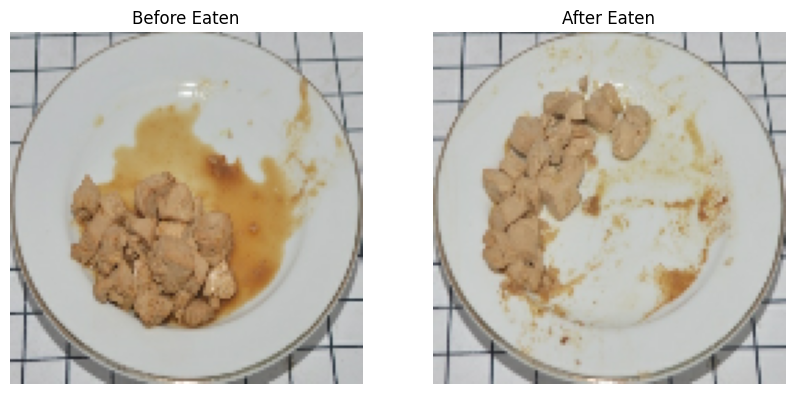

Actual percentage left: 65.00%
Model's predicted percentage left: 69.66%


In [173]:
# Cell 7: Visualize Prediction Results
if "model" in locals():
    # Select an index from the test set for prediction
    # Change this number to test different samples (e.g., 0, 1, 2, 3...)
    sample_index = 13

    sample_X = [
        np.expand_dims(X_test[0][sample_index], axis=0),
        np.expand_dims(X_test[1][sample_index], axis=0),
    ]
    sample_y_true = y_test[sample_index]

    # Make a prediction using the trained model
    predicted_percentage = model.predict(sample_X)[0][0]

    # Visualize the results
    print("\n>>> Checking prediction results")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(sample_X[0][0])
    axes[0].set_title("Before Eaten")
    axes[0].axis("off")
    axes[1].imshow(sample_X[1][0])
    axes[1].set_title("After Eaten")
    axes[1].axis("off")
    plt.show()

    print(f"Actual percentage left: {sample_y_true:.2f}%")
    print(f"Model's predicted percentage left: {predicted_percentage:.2f}%")
else:
    print(
        "Error: Model not trained. Please ensure Cell 6 has been executed first."
    )